In [1]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import rich.table
import planetary_computer
from pystac_client import Client
import cartopy
from shapely.geometry import Polygon

from IPython.display import Image

## Accessing Sentinel1 RTC data from Planetary Computer

- instructions for finding planetary computer account API key and setting environment vars 
[here](https://github.com/microsoft/PlanetaryComputer/discussions/77)
   

Following instructions from the [S1 RTC Example notebook](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc#Example-Notebook)

In [2]:
catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
catalog

<Client id=microsoft-pc>

Specify time range and bounding box of interest: 

In [3]:
time_range = '2015-01-01/2022-05-01'
bbox = [88.214935, 27.92767, 88.302,  28.034]
bbox_arr = np.array(bbox)
bbox_arr

bbox_coords = [(bbox_arr[0],bbox_arr[1]), 
               (bbox_arr[2],bbox_arr[1]),
               (bbox_arr[2],bbox_arr[3]),
               (bbox_arr[0],bbox_arr[3]),
               (bbox_arr[0],bbox_arr[1])
              ]

#bbox_poly = Polygon(bbox_coords)
#bbox_poly

#bbox_gdf = gpd.GeoDataFrame({'data':['bbox1'], 'geometry' : bbox_poly})
#bbox_gdf.to_file('/Users/emarshall/Desktop/siparcs/xr_book2/s1_bbox1.geojson', driver= 'GeoJSON')


Search for items in the collection you're interested in (here, S1 RTC) matching those parameters. 
Looks like there are 100 scenes in the dataset that match the criteria I specified:

In [4]:
bbox

[88.214935, 27.92767, 88.302, 28.034]

In [5]:
search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_range)
items = search.get_all_items()
len(items)

100

Convert to geodataframe and explore:

In [6]:
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs='epsg:4326')
df.head(1)

,geometry,datetime,platform,s1:shape,proj:bbox,proj:epsg,proj:shape,end_datetime,constellation,s1:resolution,...,sar:center_frequency,sar:resolution_range,s1:product_timeliness,sar:resolution_azimuth,sar:pixel_spacing_range,sar:observation_direction,sar:pixel_spacing_azimuth,sar:looks_equivalent_number,s1:instrument_configuration_ID,sat:platform_international_designator
0,"POLYGON ((89.80391 27.02294, 89.82898 27.27428...",2022-04-30T00:03:27.201903Z,SENTINEL-1A,"[27531, 21084]","[530180.0, 2980920.0, 798685.0, 3190410.0]",32645,"[27531, 21084]",2022-04-30 00:03:39.701264+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,7,2014-016A


In [7]:
df.explore()

In [8]:
item0 = items[0]
item1 = items[1]

Taking a look at a false color composite from a combination of VV, VH bands from the first item in the `items` list: 

In [9]:
Image(url=item1.assets['rendered_preview'].href)

## Inspect STAC metadata


In [10]:
table = rich.table.Table('key','value')
for k, v in sorted(item0.properties.items()):
    table.add_row(k, str(v))
    
table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ key                                   ┃ value                                             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ constellation                         │ Sentinel-1                                        │
│ datetime                              │ 2022-04-30T00:03:27.201903Z                       │
│ end_datetime                          │ 2022-04-30 00:03:39.701264+00:00                  │
│ platform                              │ SENTINEL-1A                                       │
│ proj:bbox                             │ [530180.0, 2980920.0, 798685.0, 3190410.0]        │
│ proj:epsg                             │ 32645                                             │
│ proj:shape                            │ [27531, 21084]                                    │
│ proj:transform                        │ [10.0, 0.0, 524470.0, 0.0, -10.0, 3191680.0, 0.0, │
│                                       │ 0.0, 1.0]                                         │
│ s1:datatake_id                        │ 336414                                            │
│ s1:instrument_configuration_ID        │ 7                                                 │
│ s1:orbit_source                       │ RESORB                                            │
│ s1:processing_level                   │ 1                                                 │
│ s1:product_timeliness                 │ Fast-24h                                          │
│ s1:resolution                         │ high                                              │
│ s1:shape                              │ [27531, 21084]                                    │
│ s1:slice_number                       │ 12                                                │
│ s1:total_slices                       │ 17                                                │
│ sar:center_frequency                  │ 5.405                                             │
│ sar:frequency_band                    │ C                                                 │
│ sar:instrument_mode                   │ IW                                                │
│ sar:looks_azimuth                     │ 1                                                 │
│ sar:looks_equivalent_number           │ 4.4                                               │
│ sar:looks_range                       │ 5                                                 │
│ sar:observation_direction             │ right                                             │
│ sar:pixel_spacing_azimuth             │ 10                                                │
│ sar:pixel_spacing_range               │ 10                                                │
│ sar:polarizations                     │ ['VV', 'VH']                                      │
│ sar:product_type                      │ GRD                                               │
│ sar:resolution_azimuth                │ 22                                                │
│ sar:resolution_range                  │ 20                                                │
│ sat:absolute_orbit                    │ 42995                                             │
│ sat:orbit_state                       │ descending                                        │
│ sat:platform_international_designator │ 2014-016A                                         │
│ sat:relative_orbit                    │ 48                                                │
│ start_datetime                        │ 2022-04-30 00:03:14.702542+00:00                  │
└───────────────────────────────────────┴───────────────────────────────────────────────────┘

In [11]:
item0.properties["sar:polarizations"]

['VV', 'VH']

## Visualize assets

load `vv` data into xarray and plot results. we'll use dask here, see scaling with dask link in example notebook

In [12]:
from distributed import Client

client = Client(processes=False)
print(client.dashboard_link)

http://128.117.11.172:8787/status


## stackstac

STAC = Spatio-Temporal Asset Catalog
STAC provides a common framework for describing and cataloging spatiotemporal assets 

STAC objects: 

**STAC Item**
unit representing single spatiotemporal asset as a GeoJSON feature plus datetime and links

**STAC Catalog**
JSON file of links that provides structure to organize, browse **STAC items**

**STAC Collection**
extension of STAC catalog w/ additional info including extents, licenses, keywords metadata etc.

**STAC API**
RESTful endpoint that enables search of STAC items

To load the identified data as xarray objects, we'll use `stackstac` which is a package that facilitates cloud-native raster geoprocessing.

stackstac.stack turns a `stack` collection into a lazy xarray.DataArray backed by dask (from docs)
- transfers STAC metadata to xarray coordinates


In [13]:
type(items)

pystac.item_collection.ItemCollection

Let's take a look at the below command where we build the object `ds`. 

We are calling stackstac.stack() which helps us build an xarray object from the spatiotemporal asset catalog. 

`stackstac.stack()` takes a STAC collection (check this) of STAC items and creates a DataArray of the STAC items reprojected to the same grid and stacked by time. The `items` object can also be a list of python dicts.

Within `stackstac.stack()`, we are calling `planetary_computer.sign()` on the items we identified earlier. This is using the API key associated with your planetary computer account. The other parameters included in `stackstac.stac()` are bounds_latlon, epsg and resolution. 

Providing the `epsg` parameter will return a DataArray reprojected to the epsg code you provide. 

The `resolution` parameter specifies the spatial resolution of the output data array, so the data will be resampled to the provided resolution. Be careful to provide this in the same units as the CRS.

`bounds_latlon` provides the spatial bounding box of the output object in degrees. If we didn't specify a bounds when we create this object, the output would be 15 GB. Clipping it to the bounds we defined above means that it's only 7 mb! 

You can check out all of the parameters that can be included when calling `stackstac.stack()` [here](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html)

In [101]:
import stackstac
#bounds_latlon=bbox,
da = stackstac.stack(
    planetary_computer.sign(items), bounds_latlon=bbox, epsg=32645, #resolution = 50
)
da

,Array,Chunk
Bytes,1.54 GiB,6.79 MiB
Shape,"(100, 2, 1188, 869)","(1, 1, 1024, 869)"
Count,800 Tasks,400 Chunks
Type,float64,numpy.ndarray


## Subset data array by orbital pass (asc or desc)

Ran into trying to select by non-dimension coords here. Discussion [here](https://github.com/pydata/xarray/issues/2028) was helpful. Is `.where(..., drop=True)` still the fastest way? Useful showing here? 

In [102]:
da = da.assign_coords({'pass_dir': da['sat:orbit_state']})

In [103]:
da_desc= da.where(da.pass_dir == 'descending', drop=True)
da_desc

,Array,Chunk
Bytes,535.59 MiB,6.79 MiB
Shape,"(34, 2, 1188, 869)","(1, 1, 1024, 869)"
Count,1141 Tasks,136 Chunks
Type,float64,numpy.ndarray


In [104]:
da_asc = da.where(da.pass_dir == 'ascending', drop=True)
da_asc

,Array,Chunk
Bytes,1.02 GiB,6.79 MiB
Shape,"(66, 2, 1188, 869)","(1, 1, 1024, 869)"
Count,1461 Tasks,264 Chunks
Type,float64,numpy.ndarray


## Converting to dB scale

Plotting the `vv` polarisation backscatter data. We can see that a few very bright pixels are dominating the entire distribution. This is becaues the data is currently in intensity units or **power scale**, which is linear. Let's transform the data to **dB scale** (a logarithmic scale) to better visualize it. There's a good discussion of SAR scales [here](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/#sar-scales)

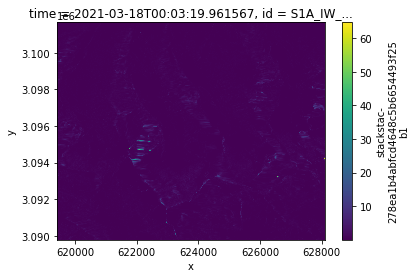

In [105]:
da.sel(band = 'vv').isel(time=2).plot()

In [106]:
def power_to_db(input_da):
    return (10*np.log10(np.abs(input_da)))

In [107]:
sigma_n_vv = power_to_db(da.sel(band='vv'))
sigma_n_vh = power_to_db(da.sel(band='vh'))
#sigma_n_vh = (10*np.log10(np.abs(da.sel(band='vh')))
sigma_n_vv

<xarray.DataArray 'stackstac-278ea1b4abfcd4648c5b6654493f25b1' (time: 100, y: 1188, x: 869)>
dask.array<mul, shape=(100, 1188, 869), dtype=float64, chunksize=(1, 1024, 869), chunktype=numpy.ndarray>
Coordinates:
  * time                                   (time) datetime64[ns] 2021-03-10T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2021...
    band                                   <U2 'vv'
  * x                                      (x) float64 6.194e+05 ... 6.281e+05
  * y                                      (y) float64 3.102e+06 ... 3.09e+06
    end_datetime                           (time) <U32 '2021-03-10 12:06:06.6...
    proj:epsg                              int64 32645
    sar:resolution_range                   int64 20
    sar:instrument_mode                    <U2 'IW'
    sar:resolution_azimuth                 int64 22
    sat:platform_international_designator  <U9 '2014-016A'
    s1:resolution                          <U4 'high'
    sar:pixel_spacing_range                int64 10
    sar:looks_equivalent_number            float64 4.4
    s1:product_timeliness                  <U8 'Fast-24h'
    constellation                          <U10 'Sentinel-1'
    sar:frequency_band                     <U1 'C'
    sat:orbit_state                        (time) <U10 'ascending' ... 'desce...
    sar:looks_range                        int64 5
    s1:instrument_configuration_ID         (time) <U1 '6' '6' '6' ... '7' '7'
    sar:polarizations                      object {'VV', 'VH'}
    s1:slice_number                        (time) <U2 '6' '6' '12' ... '6' '12'
    sar:pixel_spacing_azimuth              int64 10
    sar:observation_direction              <U5 'right'
    s1:datatake_id                         (time) <U6 '284776' ... '336414'
    sat:absolute_orbit                     (time) int64 36936 37009 ... 42995
    s1:total_slices                        (time) <U2 '21' '20' ... '20' '17'
    sar:product_type                       <U3 'GRD'
    s1:orbit_source                        (time) <U8 'PREORB' ... 'RESORB'
    sar:looks_azimuth                      int64 1
    sar:center_frequency                   float64 5.405
    platform                               <U11 'SENTINEL-1A'
    start_datetime                         (time) <U32 '2021-03-10 12:05:41.6...
    s1:processing_level                    <U1 '1'
    sat:relative_orbit                     (time) int64 114 12 48 ... 114 12 48
    description                            <U173 'Terrain-corrected gamma nau...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    title                                  <U41 'VV: vertical transmit, verti...
    epsg                                   int64 32645
    pass_dir                               (time) <U10 'ascending' ... 'desce...

Let's plot the `vv` data again to compare db scale to power scale: 

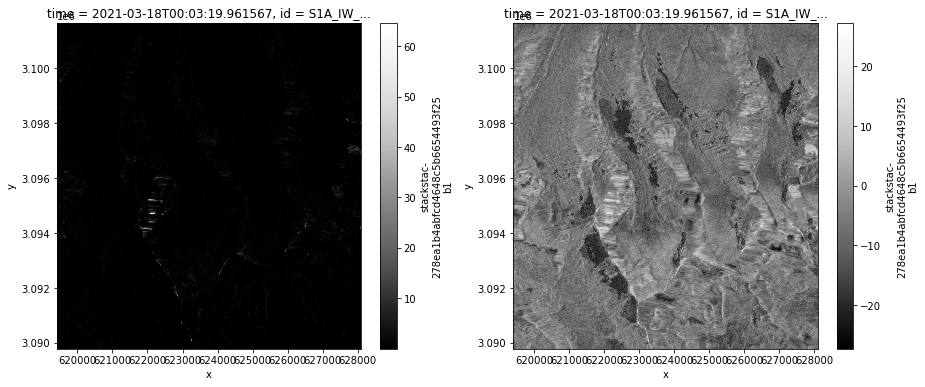

In [108]:
fig, axs = plt.subplots(ncols=2, figsize=(15,6))

da.sel(band = 'vv').isel(time=2).plot(ax=axs[0], cmap=plt.cm.Greys_r)
sigma_n_vv.isel(time=2).plot(ax=axs[1], cmap=plt.cm.Greys_r)

Viewing the backscatter data in dB scale is much more informative

## Groupby seasons

We can use `.groupby()` to group the time series into individual seasons, and then perform a reduction (mean, median...) on the backscatter data within each group:

In [109]:
gb_vv = sigma_n_vv.groupby(sigma_n_vv.time.dt.season).mean()
gb_vv

<xarray.DataArray 'stackstac-278ea1b4abfcd4648c5b6654493f25b1' (season: 4, y: 1188, x: 869)>
dask.array<stack, shape=(4, 1188, 869), dtype=float64, chunksize=(1, 1024, 869), chunktype=numpy.ndarray>
Coordinates:
    band                                   <U2 'vv'
  * x                                      (x) float64 6.194e+05 ... 6.281e+05
  * y                                      (y) float64 3.102e+06 ... 3.09e+06
    proj:epsg                              int64 32645
    sar:resolution_range                   int64 20
    sar:instrument_mode                    <U2 'IW'
    sar:resolution_azimuth                 int64 22
    sat:platform_international_designator  <U9 '2014-016A'
    s1:resolution                          <U4 'high'
    sar:pixel_spacing_range                int64 10
    sar:looks_equivalent_number            float64 4.4
    s1:product_timeliness                  <U8 'Fast-24h'
    constellation                          <U10 'Sentinel-1'
    sar:frequency_band                     <U1 'C'
    sar:looks_range                        int64 5
    sar:polarizations                      object {'VV', 'VH'}
    sar:pixel_spacing_azimuth              int64 10
    sar:observation_direction              <U5 'right'
    sar:product_type                       <U3 'GRD'
    sar:looks_azimuth                      int64 1
    sar:center_frequency                   float64 5.405
    platform                               <U11 'SENTINEL-1A'
    s1:processing_level                    <U1 '1'
    description                            <U173 'Terrain-corrected gamma nau...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    title                                  <U41 'VV: vertical transmit, verti...
    epsg                                   int64 32645
  * season                                 (season) object 'DJF' 'JJA' ... 'SON'

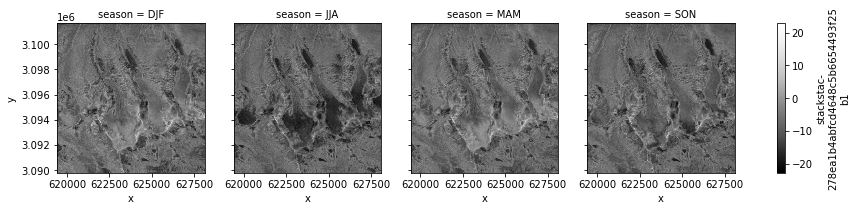

In [110]:
fg_season_vv = gb_vv.plot(col='season', cmap=plt.cm.Greys_r)

We can do the same for the `vh` polarisation

In [111]:
gb_vh = sigma_n_vh.groupby(sigma_n_vh.time.dt.season).mean()


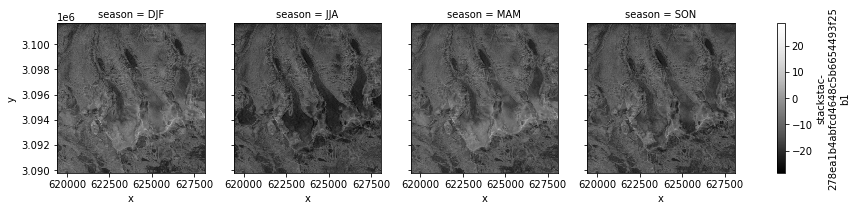

In [112]:
fg_season_vh = gb_vh.plot(col='season', cmap = plt.cm.Greys_r)

Use xarray's `facetgrid` to view the first 12 time steps

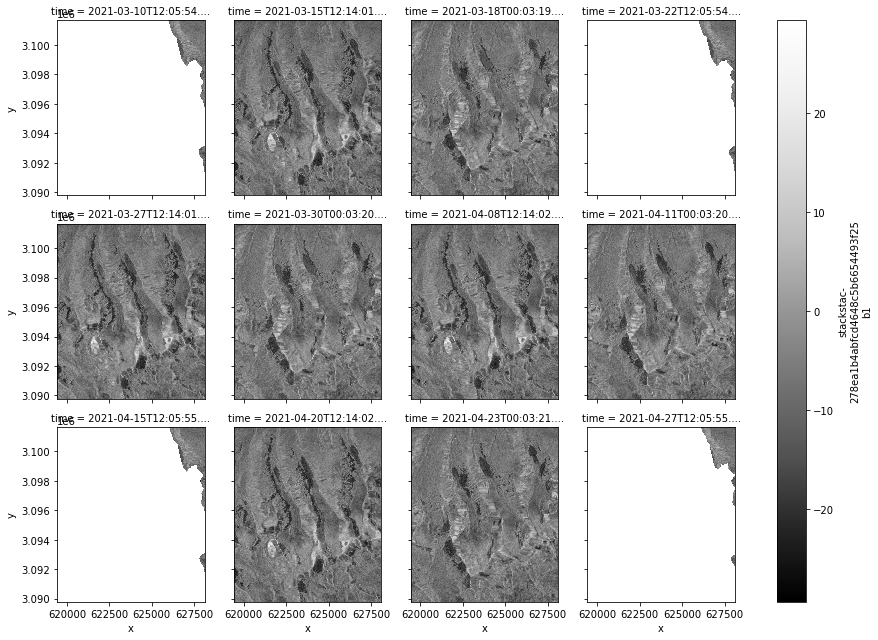

In [113]:
fg = sigma_n_vv.isel(time=slice(0,12)).plot(
    cmap=plt.cm.Greys_r,
    col='time', col_wrap =4)

## Cleaning
- polarizations come as coords but we probably want them as vars, worth making a ds? 


## Vector data 

Read in vector data to use later

In [114]:
def get_bbox_single(input_xr):
    
    '''Takes input xr object (from itslive data cube), plots a quick map of the footprint. 
    currently only working for granules in crs epsg 32645'''

    xmin = input_xr.coords['x'].data.min()
    xmax = input_xr.coords['x'].data.max()

    ymin = input_xr.coords['y'].data.min()
    ymax = input_xr.coords['y'].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]
 
    crs = input_xr.crs

    polygon_geom = Polygon(pts_ls)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 
    polygon_prj = polygon
    polygon = polygon_prj.to_crs(crs)

    #add a buffer if needed
    bounds = polygon.total_bounds
    bounds_format = [bounds[0]-15, bounds[2]+15, bounds[1]-15, bounds[3]+15]
    
    return polygon_prj

<AxesSubplot:>

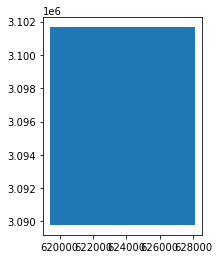

In [115]:
da_bbox = get_bbox_single(da)
da_bbox.plot()

In [116]:
rgi = gpd.read_file('https://github.com/scottyhq/rgi/raw/main/15_rgi60_SouthAsiaEast.gpkg')
rgi.head(3)
rgi_prj = rgi.to_crs('epsg:32645')

rgi_sub = gpd.sjoin(rgi_prj, da_bbox, how='inner')

`rgi_sub` should be all glaciers within the s1 bbox

In [117]:
rgi_sub.explore()

In [118]:
da_vv = da.sel(band='vv')
da_vh = da.sel(band='vh')
da_vv

<xarray.DataArray 'stackstac-278ea1b4abfcd4648c5b6654493f25b1' (time: 100, y: 1188, x: 869)>
dask.array<getitem, shape=(100, 1188, 869), dtype=float64, chunksize=(1, 1024, 869), chunktype=numpy.ndarray>
Coordinates:
  * time                                   (time) datetime64[ns] 2021-03-10T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2021...
    band                                   <U2 'vv'
  * x                                      (x) float64 6.194e+05 ... 6.281e+05
  * y                                      (y) float64 3.102e+06 ... 3.09e+06
    end_datetime                           (time) <U32 '2021-03-10 12:06:06.6...
    proj:epsg                              int64 32645
    sar:resolution_range                   int64 20
    sar:instrument_mode                    <U2 'IW'
    sar:resolution_azimuth                 int64 22
    sat:platform_international_designator  <U9 '2014-016A'
    s1:resolution                          <U4 'high'
    sar:pixel_spacing_range                int64 10
    sar:looks_equivalent_number            float64 4.4
    s1:product_timeliness                  <U8 'Fast-24h'
    constellation                          <U10 'Sentinel-1'
    sar:frequency_band                     <U1 'C'
    sat:orbit_state                        (time) <U10 'ascending' ... 'desce...
    sar:looks_range                        int64 5
    s1:instrument_configuration_ID         (time) <U1 '6' '6' '6' ... '7' '7'
    sar:polarizations                      object {'VV', 'VH'}
    s1:slice_number                        (time) <U2 '6' '6' '12' ... '6' '12'
    sar:pixel_spacing_azimuth              int64 10
    sar:observation_direction              <U5 'right'
    s1:datatake_id                         (time) <U6 '284776' ... '336414'
    sat:absolute_orbit                     (time) int64 36936 37009 ... 42995
    s1:total_slices                        (time) <U2 '21' '20' ... '20' '17'
    sar:product_type                       <U3 'GRD'
    s1:orbit_source                        (time) <U8 'PREORB' ... 'RESORB'
    sar:looks_azimuth                      int64 1
    sar:center_frequency                   float64 5.405
    platform                               <U11 'SENTINEL-1A'
    start_datetime                         (time) <U32 '2021-03-10 12:05:41.6...
    s1:processing_level                    <U1 '1'
    sat:relative_orbit                     (time) int64 114 12 48 ... 114 12 48
    description                            <U173 'Terrain-corrected gamma nau...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    title                                  <U41 'VV: vertical transmit, verti...
    epsg                                   int64 32645
    pass_dir                               (time) <U10 'ascending' ... 'desce...
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(619420.0, 3089780.0, 628110.0...
    crs:         epsg:32645
    transform:   | 10.00, 0.00, 619420.00|\n| 0.00,-10.00, 3101660.00|\n| 0.0...
    resolution:  10.0

## Convert power scale to decibel 

RTC data is processed by Planetary Computer as intensity values (gamma-nought). This is good for statistical analysis but not great for visualizing (from ASF [docs](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/)) so let's convert from gamma-nought to sigma-nought (replace for symbols). 

intensity values (linear-scale) dominated by a few bright pixels. dB (log-scale) shows the variablity in intensity. 

In [119]:
da_vv

<xarray.DataArray 'stackstac-278ea1b4abfcd4648c5b6654493f25b1' (time: 100, y: 1188, x: 869)>
dask.array<getitem, shape=(100, 1188, 869), dtype=float64, chunksize=(1, 1024, 869), chunktype=numpy.ndarray>
Coordinates:
  * time                                   (time) datetime64[ns] 2021-03-10T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2021...
    band                                   <U2 'vv'
  * x                                      (x) float64 6.194e+05 ... 6.281e+05
  * y                                      (y) float64 3.102e+06 ... 3.09e+06
    end_datetime                           (time) <U32 '2021-03-10 12:06:06.6...
    proj:epsg                              int64 32645
    sar:resolution_range                   int64 20
    sar:instrument_mode                    <U2 'IW'
    sar:resolution_azimuth                 int64 22
    sat:platform_international_designator  <U9 '2014-016A'
    s1:resolution                          <U4 'high'
    sar:pixel_spacing_range                int64 10
    sar:looks_equivalent_number            float64 4.4
    s1:product_timeliness                  <U8 'Fast-24h'
    constellation                          <U10 'Sentinel-1'
    sar:frequency_band                     <U1 'C'
    sat:orbit_state                        (time) <U10 'ascending' ... 'desce...
    sar:looks_range                        int64 5
    s1:instrument_configuration_ID         (time) <U1 '6' '6' '6' ... '7' '7'
    sar:polarizations                      object {'VV', 'VH'}
    s1:slice_number                        (time) <U2 '6' '6' '12' ... '6' '12'
    sar:pixel_spacing_azimuth              int64 10
    sar:observation_direction              <U5 'right'
    s1:datatake_id                         (time) <U6 '284776' ... '336414'
    sat:absolute_orbit                     (time) int64 36936 37009 ... 42995
    s1:total_slices                        (time) <U2 '21' '20' ... '20' '17'
    sar:product_type                       <U3 'GRD'
    s1:orbit_source                        (time) <U8 'PREORB' ... 'RESORB'
    sar:looks_azimuth                      int64 1
    sar:center_frequency                   float64 5.405
    platform                               <U11 'SENTINEL-1A'
    start_datetime                         (time) <U32 '2021-03-10 12:05:41.6...
    s1:processing_level                    <U1 '1'
    sat:relative_orbit                     (time) int64 114 12 48 ... 114 12 48
    description                            <U173 'Terrain-corrected gamma nau...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    title                                  <U41 'VV: vertical transmit, verti...
    epsg                                   int64 32645
    pass_dir                               (time) <U10 'ascending' ... 'desce...
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(619420.0, 3089780.0, 628110.0...
    crs:         epsg:32645
    transform:   | 10.00, 0.00, 619420.00|\n| 0.00,-10.00, 3101660.00|\n| 0.0...
    resolution:  10.0

<AxesSubplot:title={'center':'time = 2021-03-18T00:03:19.961567, id = S1A_IW_...'}, xlabel='x', ylabel='y'>

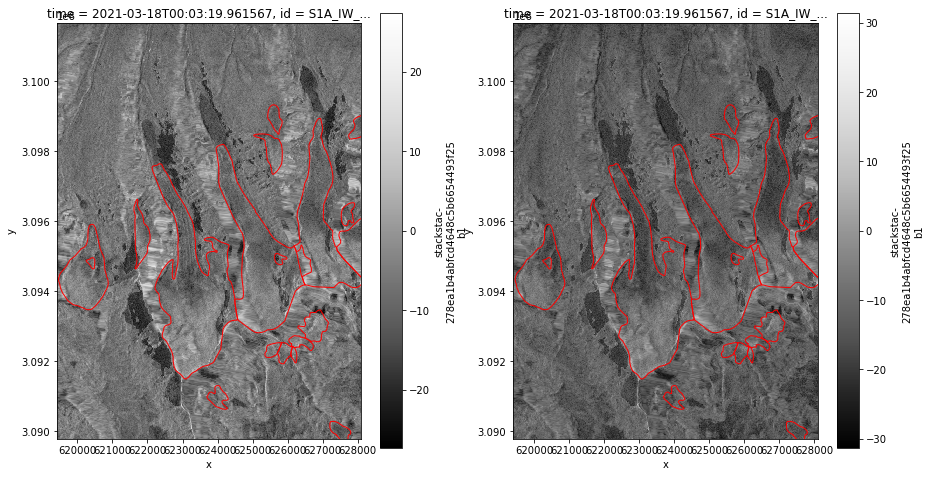

In [120]:
fig, axs = plt.subplots(ncols=2, figsize=(15,8))

sigma_n_vv.isel(time=2).plot(ax=axs[0], cmap=plt.cm.Greys_r)
rgi_sub.plot(edgecolor='r', facecolor='none', ax=axs[0])
sigma_n_vh.isel(time=2).plot(ax=axs[1], cmap=plt.cm.Greys_r)
rgi_sub.plot(edgecolor='red', facecolor='none', ax=axs[1])


## Comparing Planetary Computer RTC image with ASF RTC image

This RTC image was processed by the ASF On Demand processing service. It is in power scale

In [121]:
asf_rtc = xr.open_dataset('/Users/emarshall/Desktop/siparcs/xr_book2/S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58/S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58_VV.tif',
                             chunks = 'auto')
asf_rtc


<xarray.Dataset>
Dimensions:      (band: 1, x: 9724, y: 7507)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.196e+05 5.196e+05 ... 8.112e+05 8.113e+05
  * y            (y) float64 3.201e+06 3.201e+06 3.2e+06 ... 2.975e+06 2.975e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 6900, 4862), meta=np.ndarray>

In [122]:
asf_rtc.band_data

<xarray.DataArray 'band_data' (band: 1, y: 7507, x: 9724)>
dask.array<open_dataset-e5a55a0efd578f2f22a3d979cb531bd7band_data, shape=(1, 7507, 9724), dtype=float32, chunksize=(1, 6900, 4862), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.196e+05 5.196e+05 ... 8.112e+05 8.113e+05
  * y            (y) float64 3.201e+06 3.201e+06 3.2e+06 ... 2.975e+06 2.975e+06
    spatial_ref  int64 ...

Convert to dB scale:

In [123]:
asf_db = power_to_db(asf_rtc)
asf_db

<xarray.Dataset>
Dimensions:      (band: 1, x: 9724, y: 7507)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.196e+05 5.196e+05 ... 8.112e+05 8.113e+05
  * y            (y) float64 3.201e+06 3.201e+06 3.2e+06 ... 2.975e+06 2.975e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 6900, 4862), meta=np.ndarray>

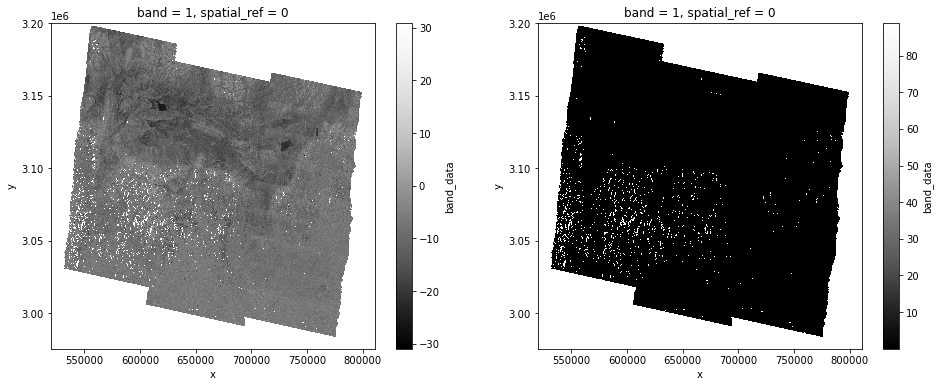

In [124]:
fig, axs = plt.subplots(ncols=2, figsize=(16,6))
asf_db.band_data.plot(ax=axs[0], cmap=plt.cm.Greys_r)
asf_rtc.band_data.plot(ax=axs[1], cmap=plt.cm.Greys_r)

Clip the ASF object to the same spatial extent as the PC subset: 

In [125]:
asf_subset = asf_rtc.rio.clip(da_bbox.geometry, da_bbox.crs)
asf_db_subset= asf_db.rio.clip(da_bbox.geometry, da_bbox.crs)
asf_db_subset

<xarray.Dataset>
Dimensions:      (y: 396, x: 290, band: 1)
Coordinates:
  * y            (y) float64 3.102e+06 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
  * x            (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

In [126]:
sigma_n_vv.sel(time='2022-04-30')
#sigma_n_vv

<xarray.DataArray 'stackstac-278ea1b4abfcd4648c5b6654493f25b1' (time: 1, y: 1188, x: 869)>
dask.array<getitem, shape=(1, 1188, 869), dtype=float64, chunksize=(1, 1024, 869), chunktype=numpy.ndarray>
Coordinates:
  * time                                   (time) datetime64[ns] 2022-04-30T0...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2022...
    band                                   <U2 'vv'
  * x                                      (x) float64 6.194e+05 ... 6.281e+05
  * y                                      (y) float64 3.102e+06 ... 3.09e+06
    end_datetime                           (time) <U32 '2022-04-30 00:03:39.7...
    proj:epsg                              int64 32645
    sar:resolution_range                   int64 20
    sar:instrument_mode                    <U2 'IW'
    sar:resolution_azimuth                 int64 22
    sat:platform_international_designator  <U9 '2014-016A'
    s1:resolution                          <U4 'high'
    sar:pixel_spacing_range                int64 10
    sar:looks_equivalent_number            float64 4.4
    s1:product_timeliness                  <U8 'Fast-24h'
    constellation                          <U10 'Sentinel-1'
    sar:frequency_band                     <U1 'C'
    sat:orbit_state                        (time) <U10 'descending'
    sar:looks_range                        int64 5
    s1:instrument_configuration_ID         (time) <U1 '7'
    sar:polarizations                      object {'VV', 'VH'}
    s1:slice_number                        (time) <U2 '12'
    sar:pixel_spacing_azimuth              int64 10
    sar:observation_direction              <U5 'right'
    s1:datatake_id                         (time) <U6 '336414'
    sat:absolute_orbit                     (time) int64 42995
    s1:total_slices                        (time) <U2 '17'
    sar:product_type                       <U3 'GRD'
    s1:orbit_source                        (time) <U8 'RESORB'
    sar:looks_azimuth                      int64 1
    sar:center_frequency                   float64 5.405
    platform                               <U11 'SENTINEL-1A'
    start_datetime                         (time) <U32 '2022-04-30 00:03:14.7...
    s1:processing_level                    <U1 '1'
    sat:relative_orbit                     (time) int64 48
    description                            <U173 'Terrain-corrected gamma nau...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    title                                  <U41 'VV: vertical transmit, verti...
    epsg                                   int64 32645
    pass_dir                               (time) <U10 'descending'

## Comare the PC and ASF RTC images side-by-side 

Text(0.5, 1.0, 'Planetary Computer RTC image')

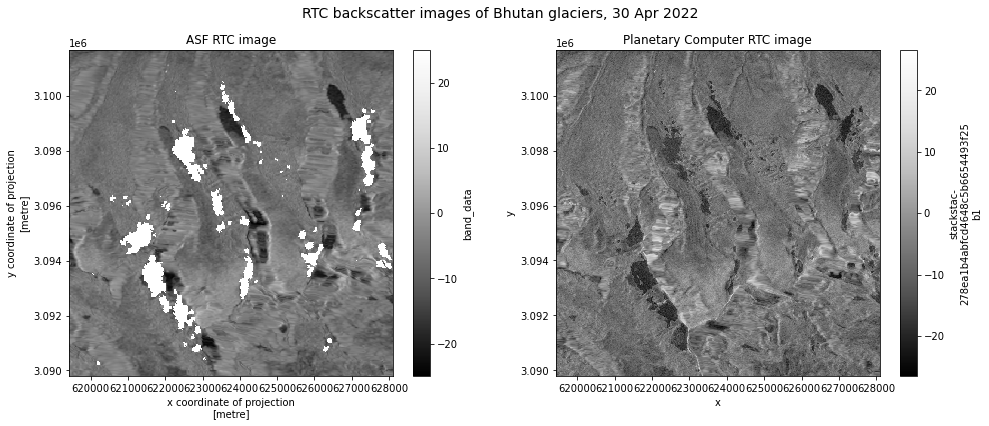

In [132]:
fig, axs = plt.subplots(ncols=2, figsize=(16,6))
asf_db_subset.band_data.plot(ax=axs[0], cmap=plt.cm.Greys_r)
sigma_n_vv.sel(time='2022-04-30').plot(ax=axs[1], cmap=plt.cm.Greys_r)

fig.suptitle('RTC backscatter images of Bhutan glaciers, 30 Apr 2022', fontsize=14)
axs[0].set_title('ASF RTC image')
axs[1].set_title('Planetary Computer RTC image')

In [128]:
!ls /Users/emarshall/Desktop/siparcs/xr_book2/S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58

S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58.README.md.txt
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58.kmz
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58.log
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58.png
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58.png.aux.xml
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58.png.xml
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58_VH.tif
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58_VH.tif.xml
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58_VV.tif
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58_VV.tif.xml
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58_ls_map.tif
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58_ls_map.tif.xml
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58_rgb.kmz
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58_rgb.png
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58_rgb.png.aux.xml
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58_rgb.png.xml
S1A_IW_20220430T000313_DVP_RTC30_G_gpuned_CE58_shape.dbf
S1A_IW_20220430T000313_DVP_RTC30_G_gpun